In [120]:
#from styx_msgs.msg import TrafficLight
import os
import cv2
import tensorflow as tf
import numpy as np
#import rospy
import time
#import rospkg
#from cv_bridge import CvBridge
#from std_msgs.msg import Bool
#from sensor_msgs.msg import Image

from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

# extract traffic light box with maximal confidence
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])
#
# Utility funcs
#
def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)

    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].

    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width

    return box_coords

def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)

def extract(img, boxes, classes):
    listofimages = list()
    #iterate through all found boxes in the image
    for i in range(len(boxes)):
        # get coordinates
        y1, x1, y2, x2 = boxes[i, ...]
        print(y1,x1,y2,x2)
        class_id = int(classes[i])
        # crop image and store into list
        if(class_id == 10):
            img2 = img.copy()
            img2 = img2[int(y1):int(x1),int(y2):int(x2)]
            listofimages.append(img2)
    return listofimages


class Escargo_classifier(object):
    def __init__(self, model_path = None):
        if model_path is None:
            '''
            rp = rospkg.RosPack()
            # model folder in tl_detector folder
            model_path = os.path.join(rp, get_path('tl_detector'), 'model')
            '''
        self.manual_test = True
        # Create Log info?
        if self.manual_test:
            detection_model_path = 'model/frozen_inference_graph.pb'
            classification_model_path = 'model/model_classification.pb'
        else:
            detection_model_path = os.path.join(model_path, 'model_detection.pb')
            classification_model_path = os.path.join(model_path, 'model_classification.pb')
        # check if models exists and output error?

        self.config = tf.ConfigProto() #check what that is
        # load graphs
        self.detection_graph = load_graph(detection_model_path)
        self.classification_graph = load_graph(classification_model_path)

        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')

        self.config = tf.ConfigProto()
        # Create TF sessions
        self.sess_detection = tf.Session(graph=self.detection_graph, config=self.config)
        self.sess_classification = tf.Session(graph=self.classification_graph, config=self.config)
        self.in_graph = self.classification_graph.get_tensor_by_name('input_1:0')
        self.out_graph = self.classification_graph.get_tensor_by_name('output_0:0')
        
        # Create Output from classification
        #self.index2msg = {0: TrafficLight.GREEN, 1: TrafficLight.RED, 2: TrafficLight.YELLOW}

    def load_graph(graph_file):
        graph = tf.Graph()
        with graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(graph_file, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        return graph

    def get_classification(self, image, threshold=None):
        """Determines the color of the traffic light in the image

        Args:
            image (cv::Mat): image containing the traffic light

        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)

        """
        # load image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cropped_img = self.tl_detection(image)
        if cropped_img is None:
            return TrafficLight.UNKNOWN
        traffic_light = cv2.resize(cropped_img, (32, 32))
        return self.classify_it(traffic_light)

    def tl_detection(self, image):
        h_, w_, _ = image.shape
        print("checkpoint img shape: {}".format(image.shape))
        image_np = np.expand_dims(image, axis=0)
        #with tf.Session(graph=self.detection_graph) as sess:
        with self.sess_detection.as_default(), self.detection_graph.as_default():
            # Actual detection.
            #(boxes, scores, classes) = sess.run([self.detection_boxes, self.detection_scores, self.detection_classes],
            #                                    feed_dict={self.image_tensor: image_np})
            
            boxes, scores, classes = self.sess_detection.run(
                [self.detection_boxes, self.detection_scores, self.detection_classes],
                feed_dict={self.image_tensor: image_np})
            
            # Remove unnecessary dimensions
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes)
            confidence_cutoff = 0.5
            # Filter boxes with a confidence score less than `confidence_cutoff`
            boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
            # The current box coordinates are normalized to a range between 0 and 1.
            # This converts the coordinates actual location on the image.
            box_coords = to_image_coords(boxes, h_, w_)
            # Each class with be represented by a differently colored box
            #draw_boxes(image, box_coords, classes)
            print("len classes: {}, len boxes: {}".format(len(classes), len(boxes)))
            return extract(image, box_coords, classes)


    def classify_it(self, image):
        with self.sess_classification.as_default(), self.classification_graph.as_default():
            sfmax = list(self.sess_classification.run(tf.nn.softmax(self.out_graph.eval(feed_dict={self.in_graph: [image]}))))
            sf_ind = sfmax.index(max(sfmax))
        return sf_ind
    def close(self):
        self.sess.close()


Number of colors = 148


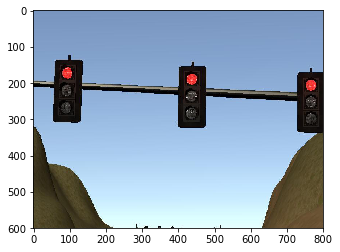

In [158]:
import matplotlib.pyplot as plt
test_image = plt.imread("./test_images_detector_node/red.jpg")
plt.imshow(test_image)

In [133]:
TestRun = Escargo_classifier()

In [159]:
imgs = TestRun.tl_detection(test_image)

checkpoint img shape: (600, 800, 3)
len classes: 3, len boxes: 3
156.605 399.313 330.344 465.362
134.851 54.2134 312.078 130.141
167.503 724.312 343.774 798.549


In [161]:
image_types = ["red", "green", "yellow"]

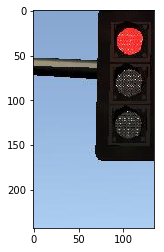

In [162]:
plt.imshow(imgs[0])

In [164]:
image = imgs[0]
traffic_light = cv2.resize(image, (32, 32))
prediction = TestRun.classify_it(traffic_light)
print(image_types[prediction])

red


green


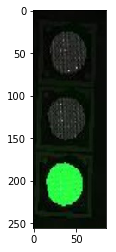

In [165]:
test_image_class = plt.imread("./test_images_detector_node/green3.jpg")
plt.imshow(test_image_class)
traffic_light1 = cv2.resize(test_image_class, (32, 32))
prediction1 = TestRun.classify_it(traffic_light1)
print(image_types[prediction1])